# 🟢 **Suggestify**: Spotify recommendation system 🟢

#### 🧑👩 Authors: Eneko Barbadillo Odriozola, Nora Ibarguren Bolinaga

#### 📚 Main dataset: https://www.kaggle.com/datasets/krishsharma0413/2-million-songs-from-mpd-with-audio-features

---

## 1.- Libraries

We'll first install the libraries that we need to run our code

In [ ]:
import sqlite3
import pandas as pd
from pyspark.sql import SparkSession
from sklearn.preprocessing import StandardScaler
from pyspark.ml.feature import VectorAssembler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples
from pyspark.sql.types import *
import sys
import os
import matplotlib.pyplot as plt
import psutil
import random
import numpy as np
import seaborn as sns
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error

## 2.- Importing the data

Now, we'll import our database into the project using the pandas library. In this case, it only contains a table named "extracted".

We spent a considerable amount of time trying to convert our dataset (which was imported as a pandas dataframe), into a Spark dataframe since it was one of the initial requirements of the project. However, due to our big amount of data, each time we tried creating the spark dataframe the kernel would die (sometimes even whithout informing us, which meant that we had this cells executing several hours, just for us to know, after 8 hours, that the kernel had died a long ago). Finally, we have worked with the pandas dataframe

In [2]:
venv_path = os.path.dirname(os.path.dirname(sys.executable))
#path to the dataset
project_path = os.path.dirname(venv_path)

In [ ]:
sqlite_conn = sqlite3.connect(project_path+"/extracted.db") #clase
#sqlite_conn = sqlite3.connect(venv_path+"/extracted.db") #portatil

cursor = sqlite_conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in SQLite:", tables)

df_og = pd.read_sql("SELECT * FROM extracted", sqlite_conn)

sqlite_conn.close()

df_og.head()

Tables in SQLite: [('extracted',)]


,track_uri,track_name,artist_name,artist_uri,album_name,album_uri,duration_ms,danceability,energy,key,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,fduration_ms,time_signature
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),Missy Elliott,spotify:artist:2wIVse2owClT7go1WT98tk,The Cookbook,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,0.904,0.813,4,...,0.0471,0.810,125.461,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4
1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Toxic,Britney Spears,spotify:artist:26dSoYclwsYLMAKD3tpOr4,In The Zone,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,0.774,0.838,5,...,0.2420,0.924,143.040,audio_features,6I9VzXrHxO9rA9A5euc8Ak,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,https://api.spotify.com/v1/tracks/6I9VzXrHxO9r...,https://api.spotify.com/v1/audio-analysis/6I9V...,198800,4
2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,Beyoncé,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Dangerously In Love (Alben für die Ewigkeit),spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,0.664,0.759,2,...,0.0598,0.701,99.252,audio_features,0WqIKmW4BTrj3eJFmnCKMv,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,https://api.spotify.com/v1/tracks/0WqIKmW4BTrj...,https://api.spotify.com/v1/audio-analysis/0WqI...,235933,4
3,spotify:track:1AWQoqb9bSvzTjaLralEkT,Rock Your Body,Justin Timberlake,spotify:artist:31TPClRtHm23RisEBtV3X7,Justified,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,0.892,0.714,4,...,0.0521,0.817,100.972,audio_features,1AWQoqb9bSvzTjaLralEkT,spotify:track:1AWQoqb9bSvzTjaLralEkT,https://api.spotify.com/v1/tracks/1AWQoqb9bSvz...,https://api.spotify.com/v1/audio-analysis/1AWQ...,267267,4
4,spotify:track:1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,Shaggy,spotify:artist:5EvFsr3kj42KNv97ZEnqij,Hot Shot,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,0.853,0.606,0,...,0.3130,0.654,94.759,audio_features,1lzr43nnXAijIGYnCT8M8H,spotify:track:1lzr43nnXAijIGYnCT8M8H,https://api.spotify.com/v1/tracks/1lzr43nnXAij...,https://api.spotify.com/v1/audio-analysis/1lzr...,227600,4


Just by taking a look at our data, we can see that every row is a now track, from which we know a lot of information, not only details such as the name of the artist or the album, but characteristics of the song, for example, danceability, key or tempo.

In [4]:
df_og.shape

(2261644, 25)

We can see that the dataset inicially has 25 columns or attributes, and overall we have 2261644 different songs!

In [5]:
df_og.info()  #column types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2261644 entries, 0 to 2261643
Data columns (total 25 columns):
 #   Column            Dtype  
---  ------            -----  
 0   track_uri         object 
 1   track_name        object 
 2   artist_name       object 
 3   artist_uri        object 
 4   album_name        object 
 5   album_uri         object 
 6   duration_ms       int64  
 7   danceability      float64
 8   energy            float64
 9   key               int64  
 10  loudness          float64
 11  mode              int64  
 12  speechiness       float64
 13  acousticness      float64
 14  instrumentalness  float64
 15  liveness          float64
 16  valence           float64
 17  tempo             float64
 18  type              object 
 19  id                object 
 20  uri               object 
 21  track_href        object 
 22  analysis_url      object 
 23  fduration_ms      int64  
 24  time_signature    int64  
dtypes: float64(9), int64(5), object(11)
memory us

In [6]:
df_og.describe()  #summary statistics

,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,fduration_ms,time_signature
count,2.261644e+06,2.261644e+06,2.261644e+06,2.261644e+06,2.261644e+06,2.261644e+06,2.261644e+06,2.261644e+06,2.261644e+06,2.261644e+06,2.261644e+06,2.261644e+06,2.261644e+06,2.261644e+06
mean,2.474756e+05,5.505030e-01,5.849327e-01,5.261526e+00,-9.659062e+00,6.549581e-01,8.924356e-02,3.547482e-01,2.208124e-01,2.090979e-01,4.757789e-01,1.200084e+02,2.474652e+05,3.880437e+00
std,1.582126e+05,1.844353e-01,2.659866e-01,3.558983e+00,5.623028e+00,4.753821e-01,1.152083e-01,3.543908e-01,3.493968e-01,1.897946e-01,2.699425e-01,2.989178e+01,1.561673e+05,4.698694e-01
min,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+03,0.000000e+00
25%,1.842930e+05,4.270000e-01,3.890000e-01,2.000000e+00,-1.190800e+01,0.000000e+00,3.540000e-02,2.220000e-02,0.000000e+00,9.570000e-02,2.470000e-01,9.695000e+01,1.843070e+05,4.000000e+00
50%,2.252875e+05,5.650000e-01,6.220000e-01,5.000000e+00,-8.175000e+00,1.000000e+00,4.700000e-02,2.150000e-01,6.030000e-04,1.280000e-01,4.660000e-01,1.200070e+02,2.252930e+05,4.000000e+00
75%,2.783060e+05,6.890000e-01,8.090000e-01,8.000000e+00,-5.826000e+00,1.000000e+00,8.380000e-02,6.910000e-01,4.210000e-01,2.640000e-01,6.970000e-01,1.380550e+02,2.783110e+05,4.000000e+00
max,2.015906e+07,9.960000e-01,1.000000e+00,1.100000e+01,4.923000e+00,1.000000e+00,9.710000e-01,9.960000e-01,1.000000e+00,1.000000e+00,1.000000e+00,2.499870e+02,6.047705e+06,5.000000e+00


In [7]:
df_og.isnull().sum()  #missing values

track_uri           0
track_name          0
artist_name         0
artist_uri          0
album_name          0
album_uri           0
duration_ms         0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
type                0
id                  0
uri                 0
track_href          0
analysis_url        0
fduration_ms        0
time_signature      0
dtype: int64

In [8]:
df_og.columns

Index(['track_uri', 'track_name', 'artist_name', 'artist_uri', 'album_name',
       'album_uri', 'duration_ms', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url',
       'fduration_ms', 'time_signature'],
      dtype='object')

After taking a look at our data, we have noticed that there's room for improvement, so we'll carry out the following transformations before continuing.

# 3.- Transformations

We create identificators for each track, artist and album, so that we can differentiate each track without using categorical variables.

In [9]:
df_og['track_id'] = df_og['track_uri'].astype('category').cat.codes
df_og['artist_id'] = df_og['artist_name'].astype('category').cat.codes
df_og['album_id'] = df_og['album_name'].astype('category').cat.codes

In the block below, we erase those variables that we won't need from our main data frame.

In [ ]:
df = df_og[["track_id", "track_name", "artist_name", "artist_id", "album_name", "album_id", "duration_ms", "danceability", "energy", "key", 
            "loudness", "mode", "speechiness","acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]]

#df_others = df_og[["track_id", "track_uri", "artist_uri", "album_uri", "type", "uri", "id", "fduration_ms", "track_href", "analysis_url"]]

We can now clean the data, and separate the numerical data from the categorical, using the id in both as identification

In [11]:
df_numerical = df[["track_id", "artist_id", "album_id", "duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]]

df_categorical = df[["track_id", "track_name", "artist_name", "album_name"]]

Finally, we can scale the numerical data in our dataset, so that we work with data in the same ranges

In [12]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numerical.drop('track_id', axis=1))

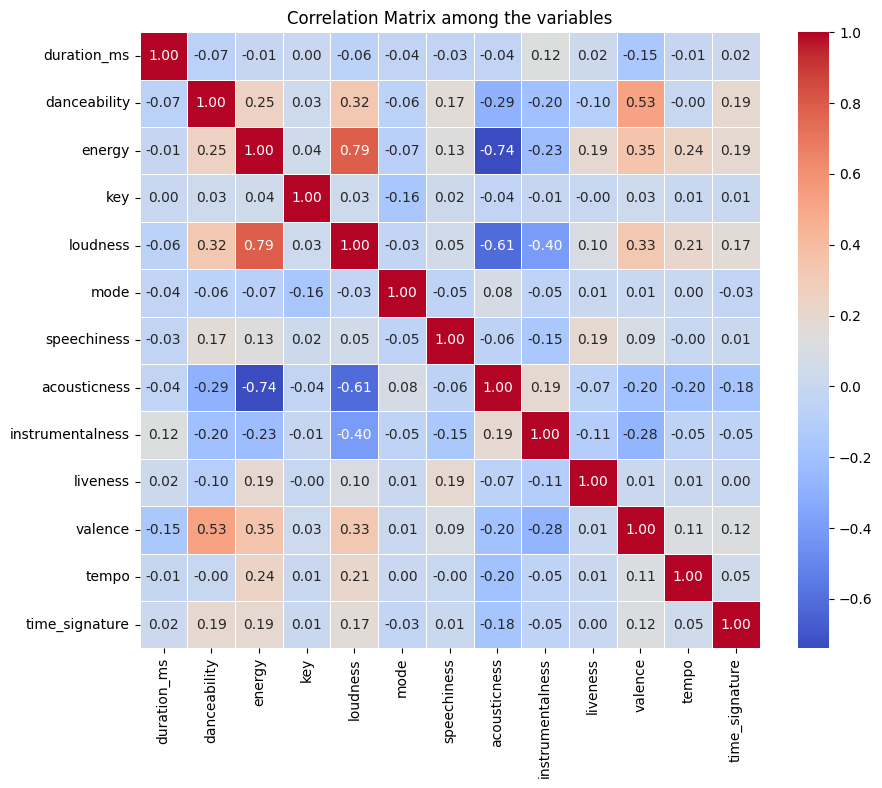

In [13]:
#correlation matrix
corr_matrix = df_numerical[["duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]].corr()

#heatmap representation
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix among the variables")
plt.show()

Taking a look at this plot, we have noticed that valence, danceability, loudness, energy are positively related, which makes sense. 
But we have also noticed multiple negative relationships, for example, acousticness and instrumentalness with energy or loudness.

This results are what we expected, and show that the data we are working with is coherent.

# 3.1.- Aditional (⚠️RATE YOUR MUSIC TOP ALBUMS)

⚠️We have also contemplated adding new data to the dataframe, related to the real ratings that the songs we are analysing have received. Our train of thought in this moment was that if we inicially recommended songs that the user knew, the initial phase would give us much more information. 

In [14]:
ratings_file = project_path + '/top_albums.csv'
df_ratings = pd.read_csv(ratings_file, delimiter=",", na_values="NaN")

#rename 'artist' to 'artist_name'
df_ratings = df_ratings.rename(columns={'artist': 'artist_name'})

#we keep only the necessary columns
df_ratings = df_ratings[['album_name', 'artist_name', 'releasedate','total_rating', 'total_reviews', 'pr_genres', 'sec_genres', 'tags']]

#merge
df_ratings = df_categorical[['track_id', 'track_name', 'artist_name', 'album_name']].merge(
    df_ratings,
    on=['album_name', 'artist_name'],
    how='right'
)

#combine columns and cleaning
df_ratings['genres'] = (
    df_ratings['pr_genres'].fillna('') + ', ' + df_ratings['sec_genres'].fillna('')
).str.strip(', ').str.replace(r',\s+,', ', ', regex=True)

#we remove the divided genres and combine them into one
df_ratings.drop(columns=['pr_genres', 'sec_genres'], inplace=True)

df_ratings['genres'] = (
    df_ratings['genres']
    .str.split(', ')
    .apply(lambda x: ', '.join(sorted(set(x))) if x != [''] else np.nan)
)


df_ratings = df_ratings.dropna(subset=['track_id'])
df_ratings = df_ratings.dropna(subset=['track_name'])

df_ratings.sort_values(by='total_reviews', ascending=False) 

,track_id,track_name,artist_name,album_name,releasedate,total_rating,total_reviews,tags,genres
1,338555.0,Subterranean Homesick Alien,Radiohead,OK Computer,16 June 1997,66322,1554,"melancholic, anxious, futuristic, existential,...","Alternative Rock, Art Rock"
2,814690.0,Paranoid Android,Radiohead,OK Computer,16 June 1997,66322,1554,"melancholic, anxious, futuristic, existential,...","Alternative Rock, Art Rock"
6,1972105.0,Lucky,Radiohead,OK Computer,16 June 1997,66322,1554,"melancholic, anxious, futuristic, existential,...","Alternative Rock, Art Rock"
7,1860365.0,Electioneering,Radiohead,OK Computer,16 June 1997,66322,1554,"melancholic, anxious, futuristic, existential,...","Alternative Rock, Art Rock"
0,2058019.0,The Tourist,Radiohead,OK Computer,16 June 1997,66322,1554,"melancholic, anxious, futuristic, existential,...","Alternative Rock, Art Rock"
...,...,...,...,...,...,...,...,...,...
5970,1864300.0,Love Theme From Chinatown (End Title) - From T...,Jerry Goldsmith,Chinatown,1974,356,2,"soothing, instrumental, atmospheric, mellow, m...","Cinematic Classical, Cool Jazz, Dark Jazz, Fil..."
5967,1335286.0,"Easy Living - From The ""Chinatown"" Soundtrack",Jerry Goldsmith,Chinatown,1974,356,2,"soothing, instrumental, atmospheric, mellow, m...","Cinematic Classical, Cool Jazz, Dark Jazz, Fil..."
5969,439638.0,"Noah Cross - From The ""Chinatown"" Soundtrack",Jerry Goldsmith,Chinatown,1974,356,2,"soothing, instrumental, atmospheric, mellow, m...","Cinematic Classical, Cool Jazz, Dark Jazz, Fil..."
5968,1901217.0,"Jake And Evelyn - From The ""Chinatown"" Soundtrack",Jerry Goldsmith,Chinatown,1974,356,2,"soothing, instrumental, atmospheric, mellow, m...","Cinematic Classical, Cool Jazz, Dark Jazz, Fil..."


In [15]:
df_mejorado = df_og.merge(
    df_ratings[['track_id', 'total_rating', 'total_reviews', 'tags', 'genres']],
    on=['track_id'],
    how='left'
)

df_mejorado

,track_uri,track_name,artist_name,artist_uri,album_name,album_uri,duration_ms,danceability,energy,key,...,analysis_url,fduration_ms,time_signature,track_id,artist_id,album_id,total_rating,total_reviews,tags,genres
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),Missy Elliott,spotify:artist:2wIVse2owClT7go1WT98tk,The Cookbook,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,0.904,0.8130,4,...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,143810,171591,469633,NaN,NaN,NaN,NaN
1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Toxic,Britney Spears,spotify:artist:26dSoYclwsYLMAKD3tpOr4,In The Zone,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,0.774,0.8380,5,...,https://api.spotify.com/v1/audio-analysis/6I9V...,198800,4,1827850,35098,232630,NaN,NaN,NaN,NaN
2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,Beyoncé,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Dangerously In Love (Alben für die Ewigkeit),spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,0.664,0.7590,2,...,https://api.spotify.com/v1/audio-analysis/0WqI...,235933,4,154482,27199,119263,NaN,NaN,NaN,NaN
3,spotify:track:1AWQoqb9bSvzTjaLralEkT,Rock Your Body,Justin Timberlake,spotify:artist:31TPClRtHm23RisEBtV3X7,Justified,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,0.892,0.7140,4,...,https://api.spotify.com/v1/audio-analysis/1AWQ...,267267,4,341116,130144,249622,NaN,NaN,NaN,NaN
4,spotify:track:1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,Shaggy,spotify:artist:5EvFsr3kj42KNv97ZEnqij,Hot Shot,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,0.853,0.6060,0,...,https://api.spotify.com/v1/audio-analysis/1lzr...,227600,4,516741,221410,216563,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2261657,spotify:track:1TtHA9GAf2HNeB3yvsDCPA,Ugly Faces,Booze & Glory,spotify:artist:4gVommn6B9vUqdsfSwVaiv,Always on the Wrong Side,spotify:album:7ewiLK5edUi37FK5EdVhD7,212600,0.544,0.8670,7,...,https://api.spotify.com/v1/audio-analysis/1TtH...,212600,4,431989,32717,33316,NaN,NaN,NaN,NaN
2261658,spotify:track:56E156pzwCerkLmEhRi0zH,"Mozart: Piano Sonata No. 7 in C Major, K. 309:...",Wolfgang Amadeus Mozart,spotify:artist:4NJhFmfw43RLBLjQvxDuRS,Mozart: Complete Piano Sonatas,spotify:album:16RpGAof6TMerrEaGfG1sL,314573,0.351,0.0711,5,...,https://api.spotify.com/v1/audio-analysis/56E1...,314573,4,1482329,277589,316926,NaN,NaN,NaN,NaN
2261659,spotify:track:05RCWXCuHfwEG5nEbsQ1j8,M.O.B.,William S. Burroughs,spotify:artist:3CcqTY5fsD6Bli5ecGhDKz,The Best Of William Burroughs From Giorno Poet...,spotify:album:3ifIM3y4zSt1gRtAFbYeGV,272133,0.530,0.3670,3,...,https://api.spotify.com/v1/audio-analysis/05RC...,272133,4,25614,276664,464833,NaN,NaN,NaN,NaN
2261660,spotify:track:19Mbai4J6Kt3DYrHL4ZyiR,O The Blood (High With Background Vocals) - [P...,Praise Hymn Tracks,spotify:artist:100OXLitsMR5uquMteikLK,O The Blood (As Made Popular By Gateway Worshi...,spotify:album:0gmGQRCjQqteZWfHRAXbZC,290840,0.409,0.1620,7,...,https://api.spotify.com/v1/audio-analysis/19Mb...,290840,4,335706,198503,340712,NaN,NaN,NaN,NaN


However, we have noticed that, because of the reduced convergence between the two datasets, the feedback our model was getting was limited to a certain type of music, and had problems exploring new genres and recommending tracks outside those genres. 

For example, if a user who enjoyed both, classical music and hard metal, were to be introduced to our model while we were contemplating this option, they would surely be introduced to metal music, but after liking the recommendations, it would miss out on all the classical tracks we could recommend, because the model would keep recomending traks that fall, more or less, on the metal genre.

We have included the code that we have followed to trial this model in model_ratings.py, in the trials folder. However, we have ended up not using it.

Additionaly, we also tried improving our model by using the song title to make better predictions. We did this using sklearn's TfidfVectorizer library. The code is in model_text.py, in the trial folders, but we finally decided not to use it in the final model, since due to the high amount of data we had, whenever we tried adding more features (TfidfVectorizer allows us to determine how many extra features we want to add), the kernel would die, end the only way of executing the model whithout killing the kernel was selecting less words for making the predictions. So few, that we considered it was not worth the extra execution time.

# 4.- PCA

Since we have a lot of variables, we have done a Principal Component Analysis, to see whether the amount of variables could be reduced to a few components and still be representative of the data.

For that, first we have analysed the rank of the dataset, and then plot the RMSE plot for each possible k, so that we can use the optimal number

Rank of X_train: 15


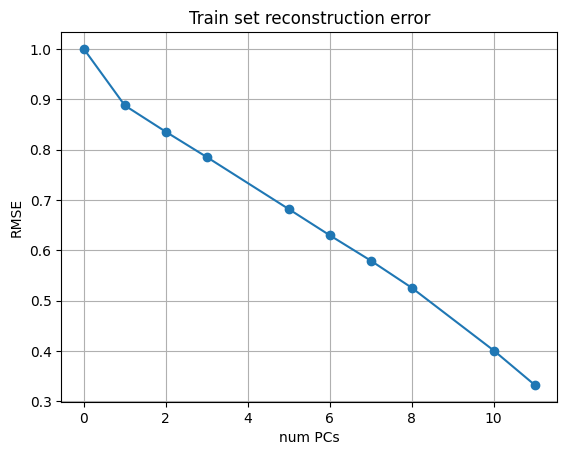

In [ ]:
X_rank = np.linalg.matrix_rank(df_scaled)
print('Rank of X_train:', X_rank)

K_linspace = np.linspace(0, 0.75 * X_rank, 10, dtype=int)  
Ks = np.unique(K_linspace)  

RMSE_train = []

if 0 in Ks:
    X_recon_k0 = np.zeros_like(df_scaled)
    mse_k0 = mean_squared_error(df_scaled, X_recon_k0)
    RMSE_train.append(np.sqrt(mse_k0))

for k in Ks[Ks > 0]:  
    pca = PCA(n_components=k)
    X_proj = pca.fit_transform(df_scaled)
    X_recon = pca.inverse_transform(X_proj)
    mse = mean_squared_error(df_scaled, X_recon)
    RMSE_train.append(np.sqrt(mse))
    
# Plot
fig, ax = plt.subplots()
ax.plot(Ks, RMSE_train, marker="o")
plt.title("Train set reconstruction error")
plt.xlabel("num PCs")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()


Looking at this plot, we have decided to go for the first 4 components of the PCA only.

For the first 4 componenets of the PCA the result is the following:

In [ ]:
pca = PCA(n_components=4) 
pca_result = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3', 'PC4'])

-----------------------------------------------
Percentage of explained variance per component:
-----------------------------------------------
[0.21213641 0.09000128 0.08149928 0.0790624 ]


Text(0, 0.5, 'Explained variance')

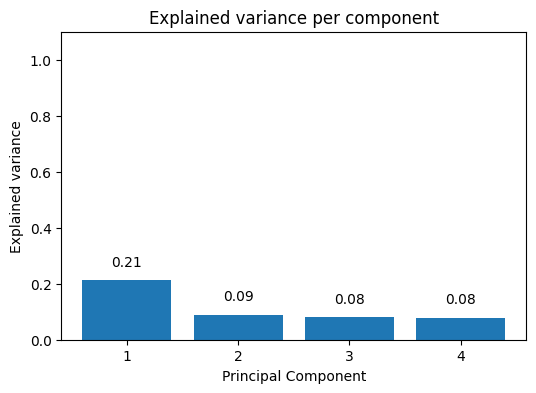

In [18]:
print('-----------------------------------------------')
print('Percentage of explained variance per component:')
print('-----------------------------------------------')
print(pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(pca.n_components_) + 1,
    height = pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(df.columns)) + 1, pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Explained variance per component')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained variance')

The percentage that each of the components explains is quite small, more so from the second component on. The first component explains the 21% of the total variance, and from then on, the components explain no more than 9%.

However, we'll analyse the results of the PCA, see the loadings each of the components has on the variables:

In [26]:
print('--------------------------------------------------------------')
print('Explainability per variable for the first PC:')
print('--------------------------------------------------------------')

#loadings of the first four components
pc1_loadings1 = np.round(pca.components_[0], decimals=3)
pc1_loadings2 = np.round(pca.components_[1], decimals=3)
pc1_loadings3 = np.round(pca.components_[2], decimals=3)
pc1_loadings4 = np.round(pca.components_[3], decimals=3)

#variable names
variables = ["artist_id", "album_id", "duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]

#df with results
df_loadings = pd.DataFrame({
    'Variable': variables,
    'PC1': pc1_loadings1,
    'PC2': pc1_loadings2,
    'PC3': pc1_loadings3,
    'PC4': pc1_loadings4,
})

print(df_loadings)

--------------------------------------------------------------
Explainability per variable for the first PC:
--------------------------------------------------------------
            Variable    PC1    PC2    PC3    PC4
0          artist_id  0.009 -0.051  0.006  0.120
1           album_id  0.004 -0.048  0.002  0.049
2        duration_ms -0.055 -0.414 -0.142 -0.120
3       danceability  0.309  0.457 -0.247 -0.098
4             energy  0.483 -0.271  0.029  0.027
5                key  0.042 -0.040 -0.242 -0.523
6           loudness  0.477 -0.142  0.021  0.113
7               mode -0.046  0.136  0.323  0.584
8        speechiness  0.119  0.167  0.428 -0.455
9       acousticness -0.428  0.302  0.102 -0.053
10  instrumentalness -0.267 -0.254 -0.316 -0.029
11          liveness  0.088 -0.224  0.621 -0.254
12           valence  0.324  0.449 -0.084  0.033
13             tempo  0.164 -0.260 -0.029  0.233
14    time_signature  0.171  0.006 -0.261  0.007


We can now conclude that the variables that most influence the PC1, and therefore the variance, are danceability, energy, loudness, acousticness, valence and instrumentalness.

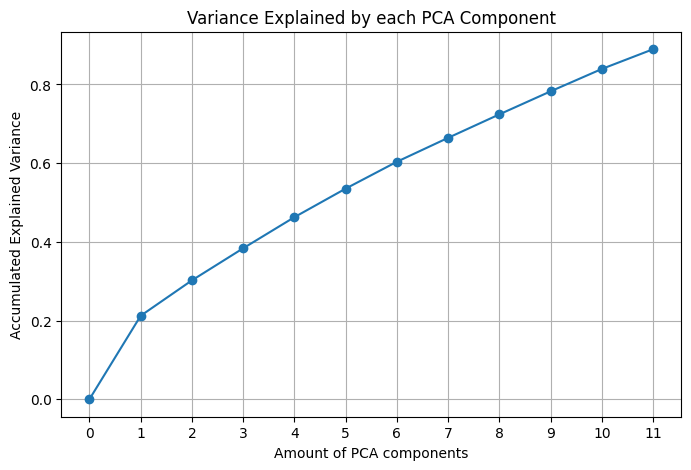

In [40]:
plt.figure(figsize=(8,5))
x_vals = np.arange(0, len(pca.explained_variance_ratio_) + 1)
y_vals = np.insert(np.cumsum(pca.explained_variance_ratio_), 0, 0)

plt.plot(x_vals, y_vals, marker='o')
plt.xlabel('Amount of PCA components')
plt.ylabel('Accumulated Explained Variance')
plt.title('Variance Explained by each PCA Component')
plt.grid()
plt.xticks(x_vals)  
plt.show()


The next step we took, was looking at the projection of each track. This way, we saw how the songs were distributed accross the first two PCA components.

In the picture below, it is clear that the first principal component, the one in the x axis, explains much more variance than the second one, seeing that the songs are mostly spreaded in horizontal.

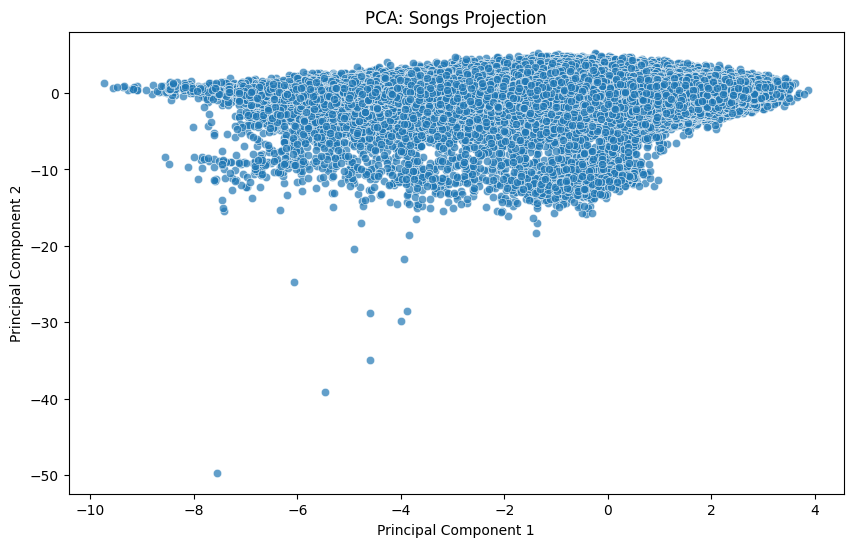

In [41]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Songs Projection')
plt.show()

### KMeans over PCA

We have now decided to group this tracks, seeing that we don't have the genre. For this, we'll calculate the within-cluster sum of squares. Our goal here is to reduce the difference of each track's attributes within one cluster. Which means that we want to maximize the simmilarities among the cluster.

In [42]:
#we'll use the PCA-transformed data (PC1, PC2)
X = df_pca[['PC1', 'PC2']]

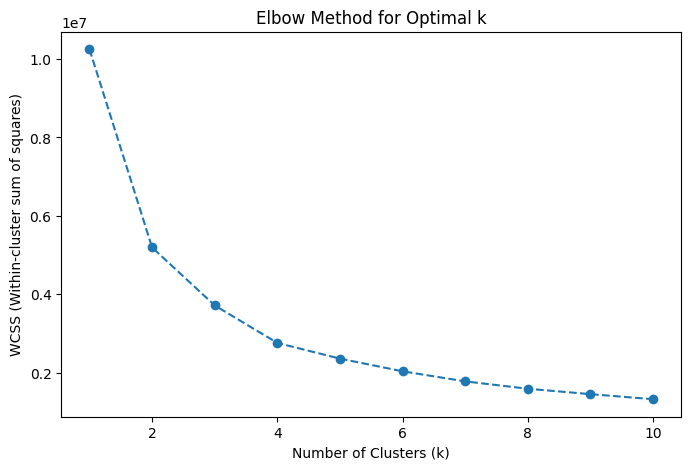

In [43]:
wcss = [] 

for k in range(1, 11):  #we'll try k values from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-cluster sum of squares)")
plt.title("Elbow Method for Optimal k")
plt.show()

Based on the elbow method shown in the plot above, the optimal amount of clusters is 4. This is the amount of groups that we'll form in the Kmeans clustering below.

In [44]:
optimal_k = 4   #based on elbow method results

In [45]:
#k-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_pca['Cluster'] = kmeans.fit_predict(X)

#centroids
centroids = kmeans.cluster_centers_

After what we have learned about the importance of the dataset being balanced, we have considered of importance to look at how many songs are in each cluster.

In [46]:
c0 = (df_pca['Cluster'] == 0).sum()
c1 = (df_pca['Cluster'] == 1).sum()
c2 = (df_pca['Cluster'] == 2).sum()
c3 = (df_pca['Cluster'] == 3).sum()

suma= c0+c1+c2+c3


prueba= pd.DataFrame()
porcentajes= [c0/suma, c1/suma, c2/suma, c3/suma]
unidades= [c0, c1, c2, c3]
prueba["percentages"]= porcentajes
prueba["units"]= unidades

print("Balance of the dataset:")
prueba

Balance of the dataset:


,percentages,units
0,0.360246,814749
1,0.126119,285236
2,0.281071,635683
3,0.232564,525976


Now, we'll classify the songs according to the cluster our Kmeans has detected. However, we have to note that in reality, we don't know how many clusters there are, nor if the classification we are doing is correct or not. We just want to approximate, and as best as possible at that.

/home/noraibarguren/volumen/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


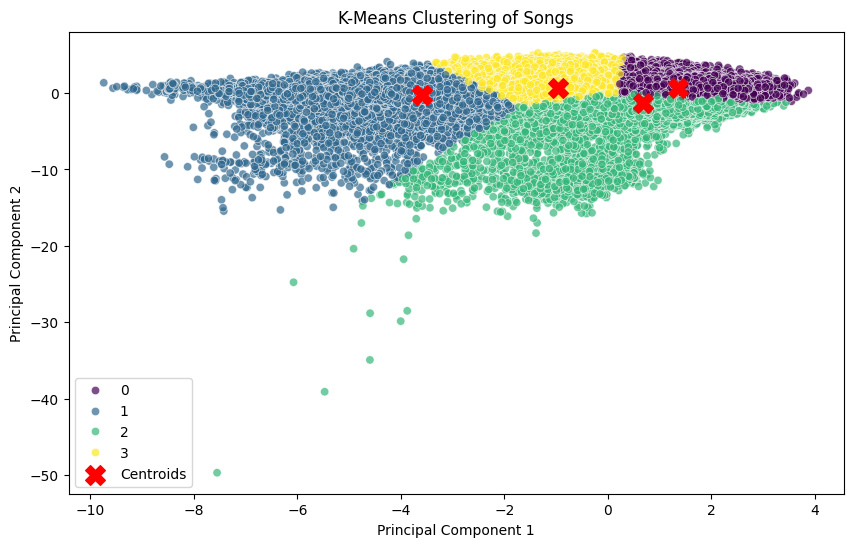

In [49]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=df_pca['Cluster'], palette='viridis', alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering of Songs')
plt.legend()
plt.show()

### Voronoi

We have also conducted a voronoi diagram to visualize the decision boundaries between clusters from K-means in the PCA-reduced space, showing which centroid new points would be assigned to.

/home/noraibarguren/volumen/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


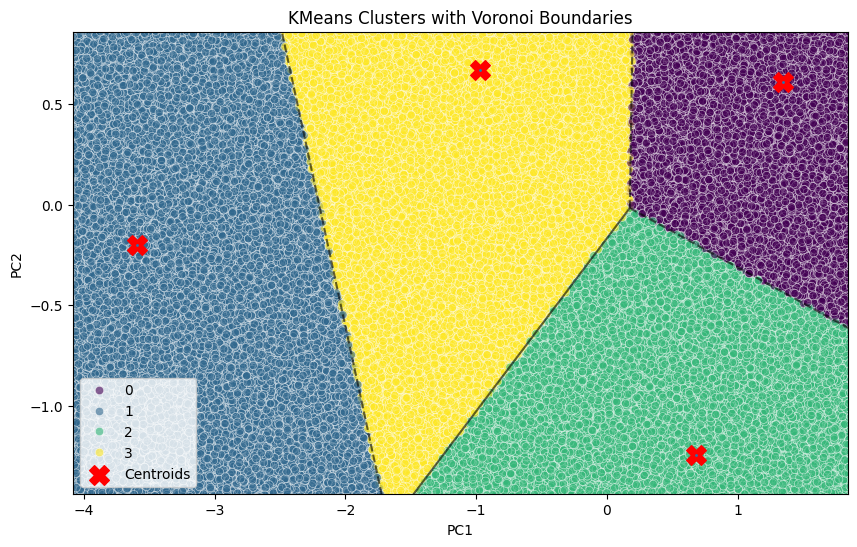

In [51]:
#create Voronoi diagram from centroids
vor = Voronoi(centroids)

#plot Voronoi over the scatterplot
fig = plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette='viridis', alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')

#overlay Voronoi regions
voronoi_plot_2d(vor, ax=plt.gca(), show_vertices=False, line_colors='black', line_width=1.5, line_alpha=0.6, point_size=2)

plt.title("KMeans Clusters with Voronoi Boundaries")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

# 5.- TSNE

Since PCA's plot don't show clean clusters, we'll try visualizing them with TSNE, which captures non-linear relationships better than PCA does.

Because the TSNE is much heavier than the PCA, we won't be applying it to all the points, but we'll take a sample.

In [59]:
#sample size
sample_size = 10000  

df = df_numerical.sample(sample_size, random_state=42)

# Standardize the sample
df_standardized = scaler.fit_transform(df)

In [60]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(df_standardized)

df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['track_name'] = df_og['track_name']
df_tsne['artist_name'] = df_og['artist_name']

Using the clusters calculated with Kmeans, we'll color each the sections corresponding to each cluster.

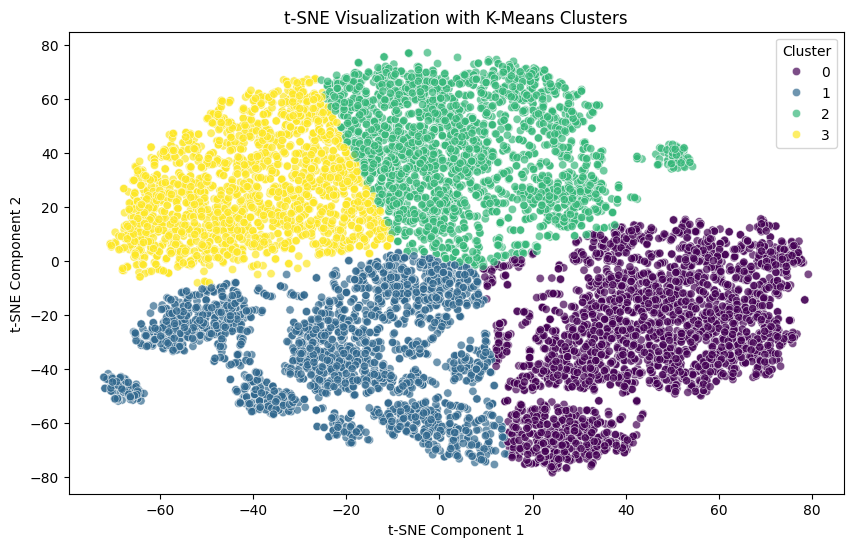

In [62]:
#Apply K-Means on t-SNE output
kmeans_tsne = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_tsne['Cluster'] = kmeans_tsne.fit_predict(X_tsne)

# Plot t-SNE with Clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_tsne['TSNE1'], y=df_tsne['TSNE2'], hue=df_tsne['Cluster'], palette='viridis', alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization with K-Means Clusters')
plt.legend(title='Cluster')
plt.show()

The dense areas show groupings that could represent different genres. However, diffuse areas can also be appreciated, were genres could blend in together.

This results in: 

In [63]:
for i in range(optimal_k):
    print(f"\nCluster {i}:")
    print(df_tsne[df_tsne['Cluster'] == i][['track_name', 'artist_name']].sample(5))


Cluster 0:
                                      track_name    artist_name
3502                           Somethin Tells Me  Bryson Tiller
559                                    Headlines          Drake
5299                              Canadian Goose   Lil Uzi Vert
7586  Fools Rush In (Where Angels Fear To Tread)    Stacey Kent
8630                            Where I Wanna Be   Donell Jones

Cluster 1:
                       track_name        artist_name
8528                 Run and Hide  Sabrina Carpenter
8993                  Sex With Me            Rihanna
5312                Déjate Llevar           J Balvin
8171  At Your Best (You Are Love)            Aaliyah
8926                  Lamborghini                KSI

Cluster 2:
                                             track_name     artist_name
405                                                  13            LANY
1195                                   I Like Me Better            Lauv
3198                                          

# 6.- Recommendation System based on the Nearest Neighbours model

With this Recommendation System, we aim to learn user preferences through gesture-based interactions (likes, dislikes, skips, and superlikes), and make personalized recommendations based on the attributes of each of the songs.

The functional code is in model.py, in the src folder. However, we'll make a small summary of what we have done, the reason behind those actions, what we have achieved, and what challenges we have faced in the way.

We have started with the data loading and preparation, which has allowed as to work better with the data. Similar to what we have done in the second and third points of this notebook, we have divided, transformed and scaled the data.

Then we have reduce its dimensionality using PCA, which makes the recommendation algorithm more efficient:

In [ ]:
numerical_features = ["artist_id", "album_id", "duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]

#use the full dataset for scaling and PCA
scaler = StandardScaler()
df_scaled_full = scaler.fit_transform(df_numerical[numerical_features])  # Full dataset

pca = PCA(n_components=4)
reduced_features_full = pca.fit_transform(df_scaled_full).astype(np.float32)

After that, we have built a Nearest Neighbors model, which allowes us to quickly find similar songs, in our case, based on the ratings of the user.

In [ ]:
#build the NearestNeighbors model with the full dataset
nn_model_full = NearestNeighbors(
    n_neighbors=50,
    metric='cosine',
    algorithm='auto',
    n_jobs=-1
).fit(reduced_features_full)

Then, so our recommendations were based on something, we first needed to recopilate data. In our case, we have started by receiving the ratings given to 20 random songs by our user. 

Scrolling right represents that we like the track, left represents the opposite, that we don't like it. Additionally scrolling up means we don't know the track or that we don't have an opinion towards it (this prevents the user from having to dislike a track, just because they didn't like it enough), and two taps on the screen represent that we looove the song.

The scores attributed to each are the following: 

- "right": 1,    # Like

- "left": -1,    # Dislike

- "up": 0,       # Skip/Neutral

- "double_click": 2  # Superlike

Based on that, the algorithm follows recommending the Nearest Neighbor to fit the user's ratings. That rating is aswell received, and the loop continues until the user closes the window, moment in which some plots are generated related to the user's ratings. The ratings of the different users are all kept in register.csv, are the plots are all in the plot folder.

The plots generated at the end are the following:
- User Position Plot: shows the user's "musical position" in the 2D PCA space relative to all songs
- User-Ratings Position Plot: shows the user's "musical position" in the 2D PCA space relative to those songs rated, which appear in different colors based on the ratings
- Rating Evolution: tracks how the user's preferences develop over time
- Gesture Distribution: visualizes the frequency of different gestures (like, dislike, etc.) to understand user behavior patterns

Also, for the visual interface, we have used the Spotify API, which has allowed us to get the album cover of each track.

Using that same API (for spotify), and, apart from that, a scrapper for SoundCloud, we tried obtaining the popularity or the views for each of the songs in our dataset, but we couldn't for two reasons:

* Spotify's API has a strict rate limit that made it impssible to us to obtain the desired values for each song.
* Souncloud didn't have many of the songs in our dataset, plus, it was taking too long for each of the existing songs.

# 7.- Density estimation

While KMeans partitions the data into k clusters by assigning each point to the nearest cluster center and updating the centers until the results don't vary through iterations, density estimation doesn't just group the data points, it models the underlying distribution of the data. KMeans is faster, but each point belongs to one and only one cluster, making it less flexible than Gaussian Mixture Models (used for density estimation).

In [ ]:
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')

    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        if covar.shape == (2, 2):
            U, s, Vt = np.linalg.svd(covar)
            angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
            w_, h_ = 2 * np.sqrt(s)
        else:
            angle = 0
            if len(covar.shape) == 1 and covar.shape[0] == 2:
                w_, h_ = 2 * np.sqrt(covar)
            elif np.isscalar(covar):
                w_ = h_ = 2 * np.sqrt(covar)
            else:
                # fallback por si hay un formato inesperado
                w_ = h_ = 1
        ax.add_patch(Ellipse(pos, width=2*w_, height=2*h_, angle=angle, edgecolor='r', fc='None', lw=1))

def evaluate_gmm_models(X, max_components=5):
    aics = []
    bics = []
    models = []

    for k in range(2, max_components + 1):
        gmm = GaussianMixture(n_components=k, random_state=42)
        gmm.fit(X)
        aics.append(gmm.aic(X))
        bics.append(gmm.bic(X))
        models.append(gmm)

    return models, aics, bics

def plot_grid_models(X, models):
    n = len(models)
    cols = 4
    rows = (n + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axs = axs.ravel()

    for i, (ax, model) in enumerate(zip(axs, models)):
        plot_gmm(model, X, ax=ax)
        ax.set_title(f'Components: {model.n_components}')
        ax.grid(True)

    # Remove unused axes
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

def plot_aic_bic(aics, bics, max_components=5):
    x = np.arange(2, max_components + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(x, aics, label='AIC', marker='o')
    plt.plot(x, bics, label='BIC', marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Score')
    plt.title('Model Selection (AIC vs BIC)')
    plt.legend()
    plt.grid(True)
    plt.show()

def density_estimation_grid(reduced_features_full):
    models, aics, bics = evaluate_gmm_models(reduced_features_full, max_components=5)
    plot_grid_models(reduced_features_full, models)
    plot_aic_bic(aics, bics)

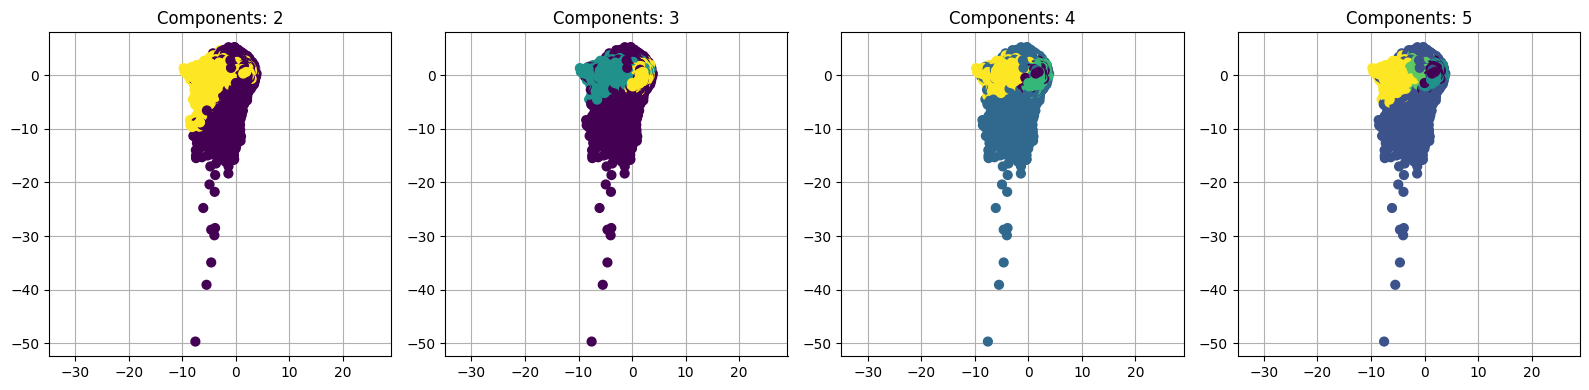

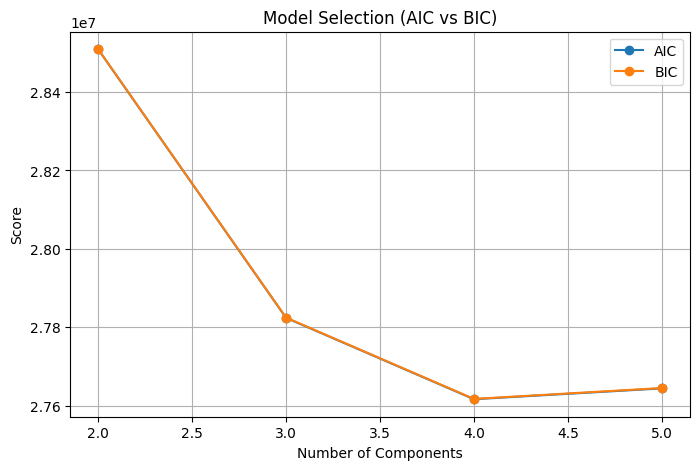

In [ ]:
density_estimation_grid(reduced_features_full)

modelos GMM de 2 a 5 componentes no difieren mucho en la cantidad de parámetros, ambos criterios penalizan de forma parecida